In [17]:
import pickle as pkl
import logomaker

Matplotlib is building the font cache; this may take a moment.


## Importing pickled dataframe

In [23]:
with open("df_4N_VCG.pkl", "rb") as file_1:
    df_4N_VCG = pkl.load(file_1)

df_4N_VCG_group = df_4N_VCG.groupby(by=["VCG_Len", "VCG"], as_index=False).count()
df_4N_VCG_group = df_4N_VCG_group[["VCG_Len", "VCG", "Seq"]]
df_4N_VCG_group

with open("VCG_DNA_list.pkl", "rb") as file_2:
    VCG_DNA_list = pkl.load(file_2)

## SeqLogo for randomized regions

In [6]:
def base_probs_for_4N(VCG: str):
    '''
    Tells us the probability of each base appearing at each position
    across every 3' 4N section that corresponds to a given VCG.

    Args:
        VCG: The virtual circular genome (VCG) whose 4Ns we want to examine.

    Returns:
        (pandas.DataFrame): 4x4 DataFrame with rows corresponding to positions (indexes) of
                            the 4N section, and columns being the four bases. The values
                            inside correspond to the probabilty that a base appears
                            at that position across all 4N sections. 
    '''

    # Grabbing the 4N sections corresponding to a specific vcg
    vcg_4Ns = df_4N_VCG.query("VCG == @VCG")["4N"]
    num_4Ns = len(vcg_4Ns)

    vcg_base_probs = {"A":[], "C":[], "T":[], "G":[]}

    # There are 4 positions in our 4N sequence
    for pos in range(4):

        # Counting how many times each base shows up in a specific position,
        # then dividing by the number of 4N replicas to give a probabilty.
        base_probs = vcg_4Ns.str[pos].value_counts() / num_4Ns
        
        # Adding this probability to our dictionary
        for base in vcg_base_probs:
            vcg_base_probs[base].append(base_probs[base])

    # Converting our dict to a DataFrame
    return pd.DataFrame(vcg_base_probs)

In [7]:
def base_probs_for_5_adap_4N(VCG: str):
    '''
    Tells us the probability of each base appearing at each position
    across every 5' 4N section that corresponds to a given VCG.

    Args:
        VCG: The virtual circular genome (VCG) whose 4Ns we want to examine.

    Returns:
        (pandas.DataFrame): 4x4 DataFrame with rows corresponding to positions (indexes) of
                            the 4N section, and columns being the four bases. The values
                            inside correspond to the probabilty that a base appears
                            at that position across all 4N sections. 
    '''

    # Grabbing the 4N sections corresponding to a specific vcg
    vcg_4Ns = df_4N_VCG.query("VCG == @VCG")["5_Adap"]
    num_4Ns = len(vcg_4Ns)

    vcg_base_probs = {"A":[], "C":[], "T":[], "G":[]}

    # There are 4 positions in our 4N sequence
    for pos in range(4):

        # Counting how many times each base shows up in a specific position,
        # then dividing by the number of 4N replicas to give a probabilty.
        base_probs = vcg_4Ns.str[pos].value_counts() / num_4Ns
        
        # Adding this probability to our dictionary
        for base in vcg_base_probs:
            vcg_base_probs[base].append(base_probs[base])

    # Converting our dict to a DataFrame
    return pd.DataFrame(vcg_base_probs)

In [8]:
def base_probs_are_abnormal(base_probs_df, max_prob_thresh=0.51, min_prob_thresh=0.07):
    '''
    Tells the user whether the probabilities for each base across a range
    of positions is "abnormal," where abnormal is defined as anything outside
    the bounds of the max/min probabilities.
    In a perfectly normal prob. count, each base would appear ~1/4 of the time at each
    position.

    Args:
        base_probs_df (pandas.DataFrame): each row represents a position in our 
                                          sequence, while the columns tell us the prob. for a specific
                                          base to appear at the position.
        max_prob_thresh (float): maximum probability that a base can have before it is considered "abnormal"
        min_prob_thresh (float): minimum probability that a base can have before it is considered "abnormal"

    Returns:
        (bool): Whether any of the freqs. were outside min/max bounds.
    '''
    max_prob = base_probs_df.to_numpy().max()
    min_prob = base_probs_df.to_numpy().min()

    return (max_prob > max_prob_thresh) or (min_prob < min_prob_thresh)

# are_base_feqs_abnormal(vcg_nt_prob_df)

In [9]:
def seq_logo_graph(probs_df, title: str):
    '''
    Converts a nucleotide probability matrix for a specific sequence
    into a Sequence Logo.

    Args:
        probs_df (pandas.DataFrame): probability matrix
        title: title of the Seq. Logo graph

    Returns:
        (logomaker.Logo): Graph showing the probabilities of each base at each position
    '''

    # create Logo object
    seq_logo = logomaker.Logo(probs_df,
                            width=.8,
                            vpad=.05,
                            #  fade_probabilities=True,
                            stack_order='small_on_top',
                            color_scheme='classic')

    # style using Logo methods
    seq_logo.style_spines(spines=['left', 'right'], visible=False)

    # style using Axes methods
    seq_logo.ax.set_title(title)
    seq_logo.ax.set_xticks(range(4))
    seq_logo.ax.set_xticklabels([str(i+1) for i in range(4)])
    seq_logo.ax.set_xlabel('position')
    seq_logo.ax.set_yticks([0, .5, 1])
    # seq_logo.ax.axvline(2.5, color='k', linewidth=1, linestyle=':')
    seq_logo.ax.set_ylabel('probability')

    return seq_logo

# seq_logo_graph(vcg_nt_prob_df, f"VCG: {vcg}")

### Trying to find the optimal max / min probability thresholds so we don't have to look through all the VCG graphs, but so that we also have enough data to look over.

In [15]:

for VCG in VCG_DNA_list:
    base_probs = base_probs_for_4N(VCG)
    abnormal   = base_probs_are_abnormal(base_probs, max_prob_thresh=0.8, min_prob_thresh=0.06)

    max_prob = base_probs.to_numpy().max()
    min_prob = base_probs.to_numpy().min()

    # print(base_probs)
    if abnormal:
        print(VCG, max_prob, min_prob)
    # print(min_prob)
    # print(abnormal)

GT 0.8473895582329317 0.039491298527443104
ATG 0.4354995150339476 0.05431619786614937
CAC 0.5437881873727087 0.05770536320434488
CGT 0.9215155615696887 0.014884979702300407
GCG 0.5024330900243309 0.030413625304136254
GGT 0.7573839662447257 0.05485232067510549
TGG 0.41627906976744183 0.05930232558139535
TGT 0.8640522875816994 0.027450980392156862
ACGC 0.6406779661016949 0.05508474576271186
GCGT 0.9098265895953758 0.019653179190751446
GTGT 0.7550776583034647 0.05734767025089606
TGCG 0.5850622406639004 0.03319502074688797
TGGT 0.7454337899543378 0.0547945205479452
ATGCG 0.5531475748194015 0.029927760577915376
CACGC 0.6041237113402061 0.05979381443298969
TGCGT 0.9331619537275064 0.010282776349614395
ACACGC 0.6340057636887608 0.05763688760806916
ATGCGT 0.9067201604814443 0.028084252758274825
GCGTGT 0.7438136826783115 0.056768558951965066
GTGGTG 0.6530880420499343 0.05913272010512484
TGTGGTG 0.6136662286465178 0.051248357424441525
ATGCGTGT 0.6845386533665836 0.05610972568578554
GTGTGGTG 0.59

### Seems like a max prob of 0.8 and a min of 0.06 gives us just the right amount of data.

          A         C         T         G
0  0.039491  0.048862  0.064257  0.847390
1  0.125837  0.401606  0.303882  0.168675
2  0.141232  0.234940  0.351406  0.272423
3  0.212182  0.240295  0.200134  0.347390
          A         C         T         G
0  0.393792  0.294859  0.054316  0.257032
1  0.088264  0.313288  0.349176  0.249273
2  0.133851  0.207565  0.435500  0.223084
3  0.222114  0.124151  0.276431  0.377304
          A         C         T         G
0  0.174474  0.224033  0.057705  0.543788
1  0.209776  0.211813  0.489477  0.088934
2  0.213849  0.171758  0.286490  0.327902
3  0.265445  0.146640  0.372709  0.215207
          A         C         T         G
0  0.033829  0.014885  0.029770  0.921516
1  0.070365  0.106901  0.637348  0.185386
2  0.155616  0.224628  0.159675  0.460081
3  0.197564  0.327470  0.231394  0.243572
          A         C         T         G
0  0.375912  0.030414  0.242092  0.351582
1  0.120438  0.074209  0.502433  0.302920
2  0.165450  0.316302  0.343066  0

C:\Users\Liam Hade\Desktop\ool_lab_venv\lib\site-packages\logomaker\src\Logo.py:194: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=self.figsize)


          A         C         T         G
0  0.092269  0.167082  0.056110  0.684539
1  0.122195  0.230673  0.340399  0.306733
2  0.224439  0.139651  0.440150  0.195761
3  0.278055  0.203242  0.309227  0.209476
          A         C         T         G
0  0.498361  0.200000  0.054098  0.247541
1  0.124590  0.136066  0.595082  0.144262
2  0.234426  0.236066  0.359016  0.170492
3  0.267213  0.209836  0.293443  0.229508
          A         C         T         G
0  0.174397  0.235622  0.057514  0.532468
1  0.144712  0.155844  0.517625  0.181818
2  0.200371  0.205937  0.387755  0.205937
3  0.291280  0.209647  0.319109  0.179963
          A         C         T         G
0  0.190942  0.258262  0.055080  0.495716
1  0.127295  0.188494  0.525092  0.159119
2  0.211750  0.199510  0.384333  0.204406
3  0.292534  0.203182  0.294982  0.209302
          A         C         T         G
0  0.461832  0.198473  0.053435  0.286260
1  0.104962  0.190840  0.547710  0.156489
2  0.192748  0.208015  0.425573  0

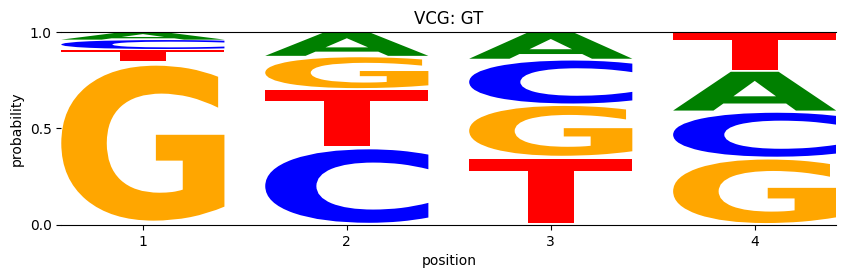

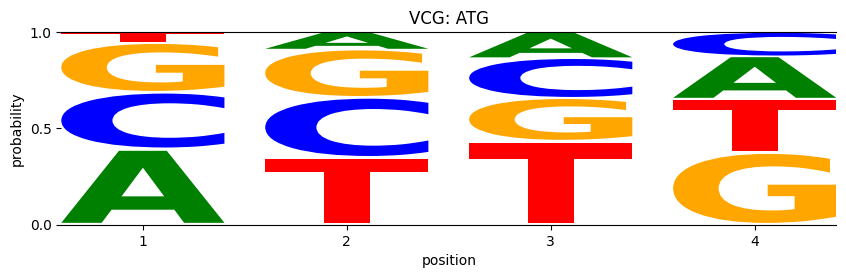

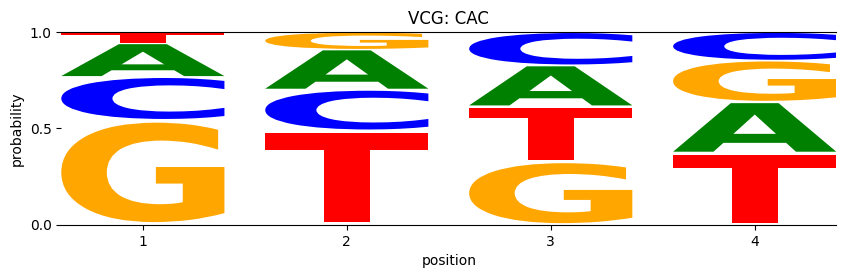

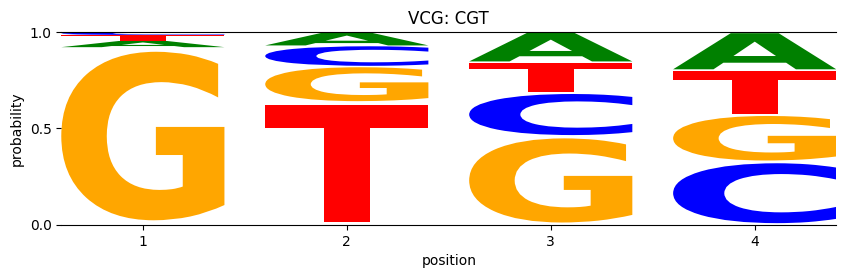

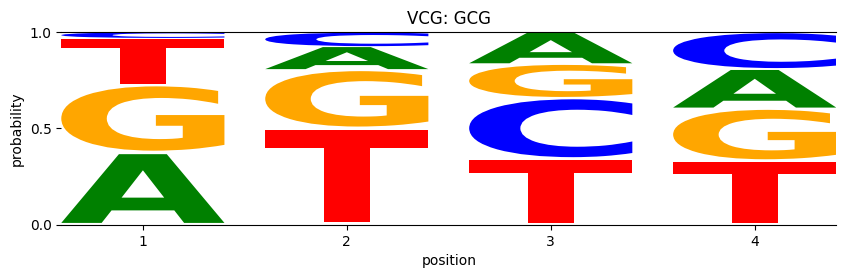

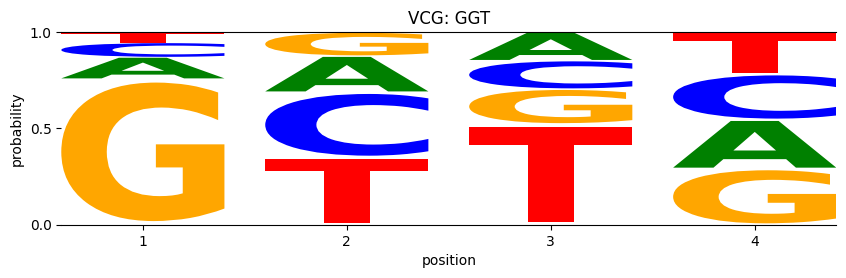

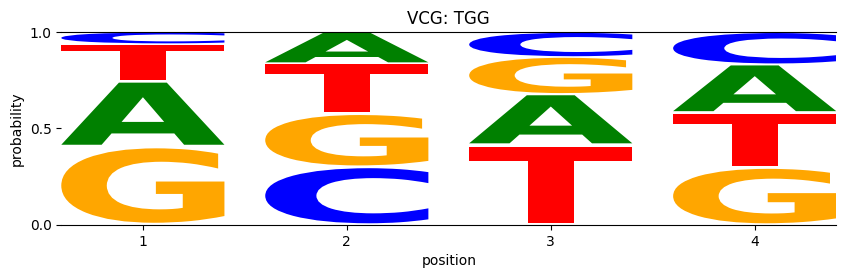

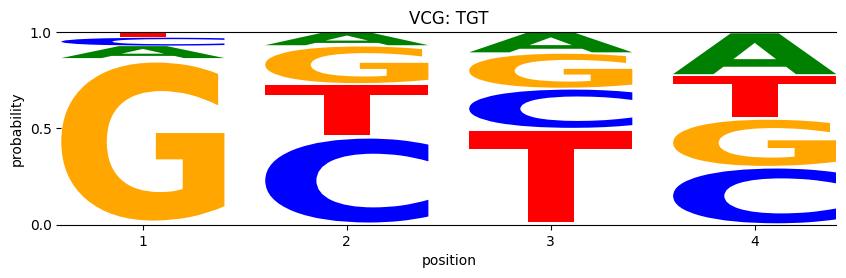

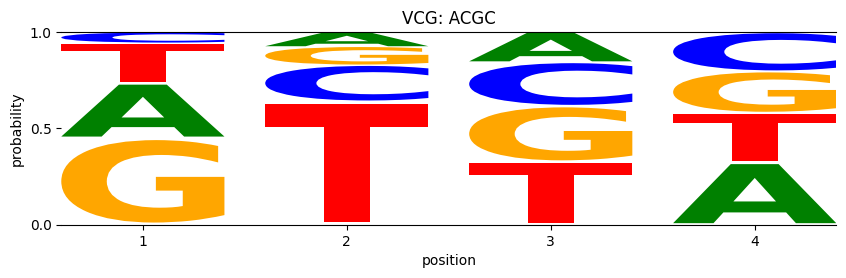

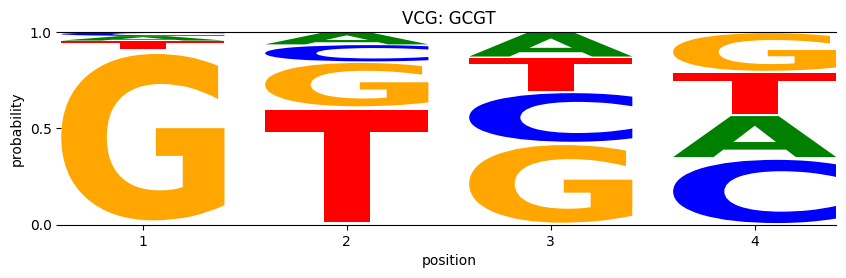

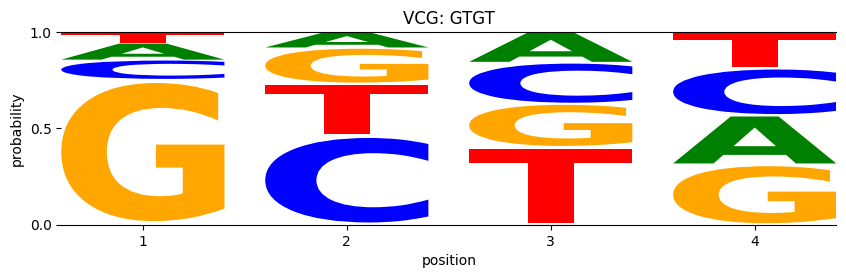

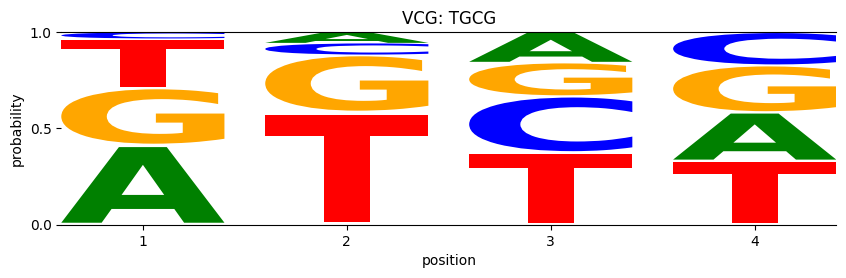

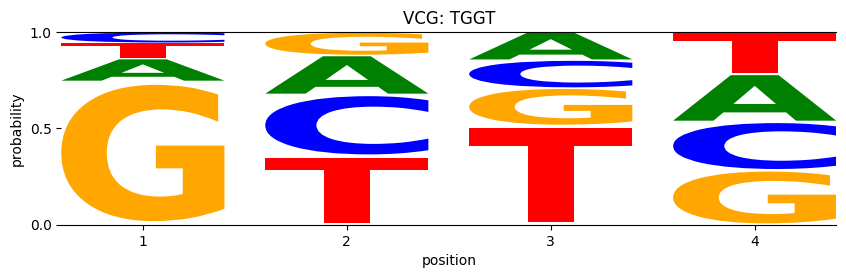

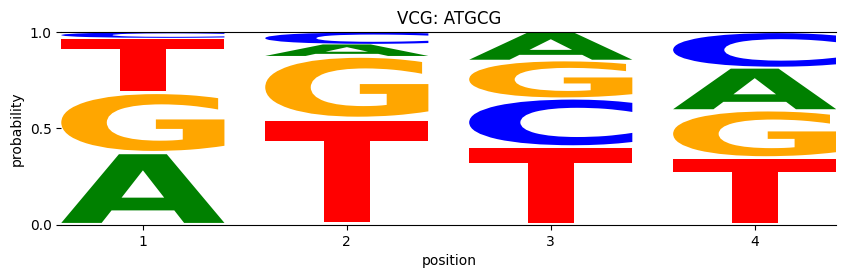

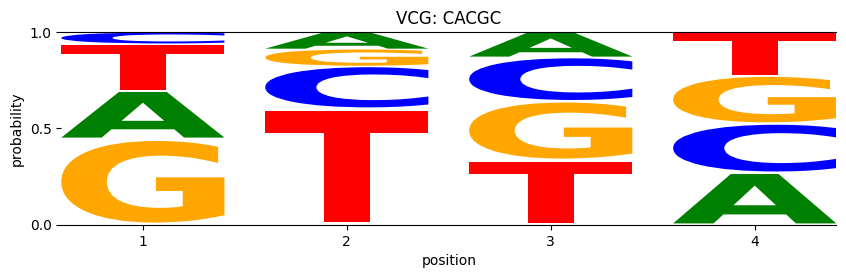

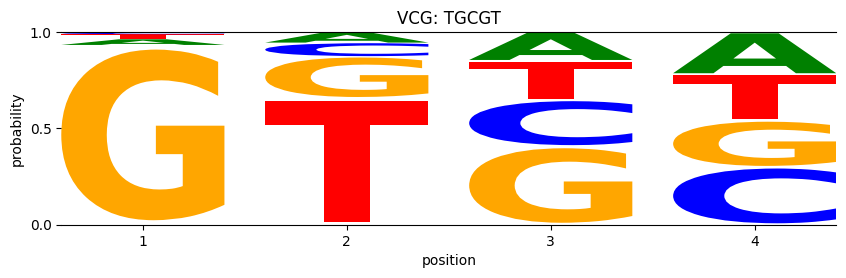

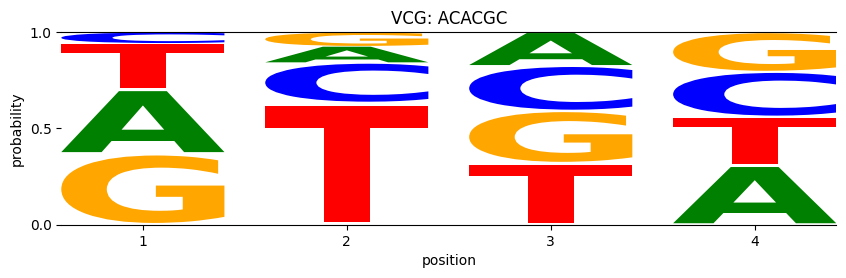

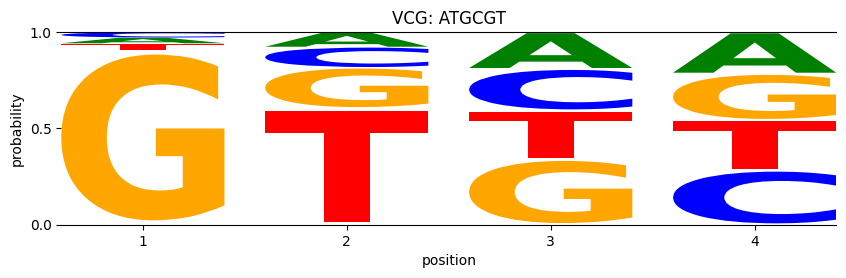

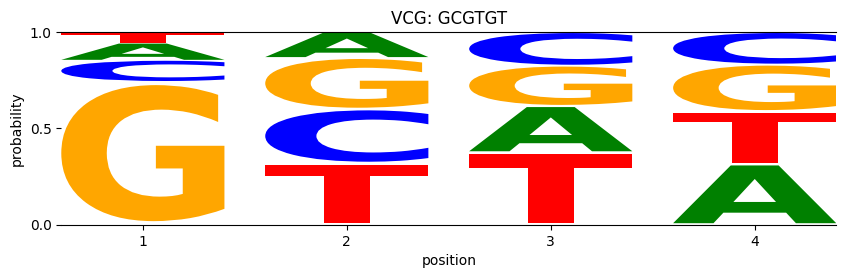

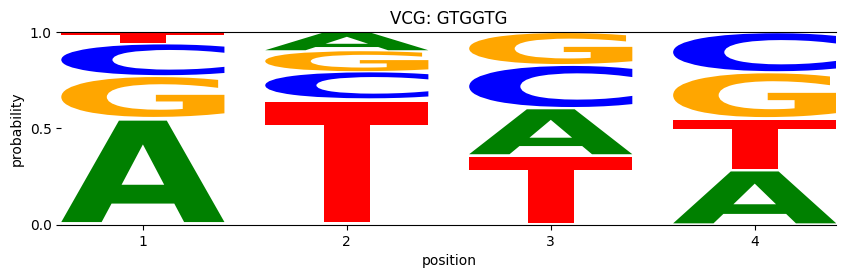

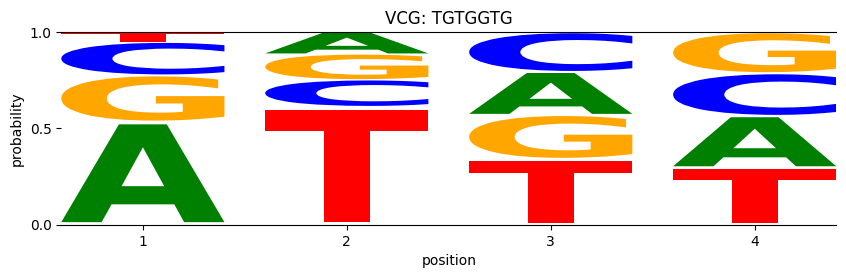

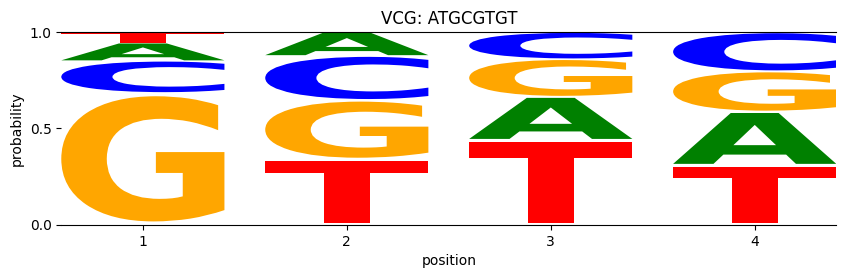

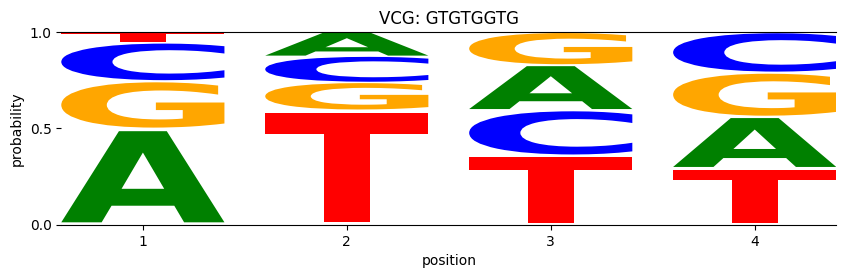

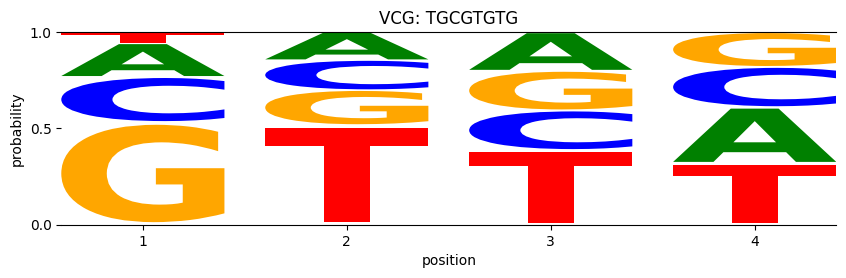

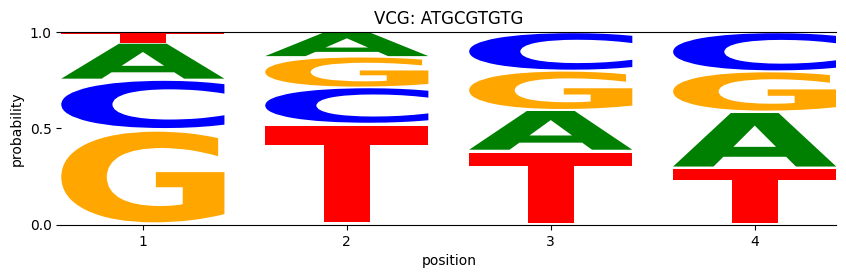

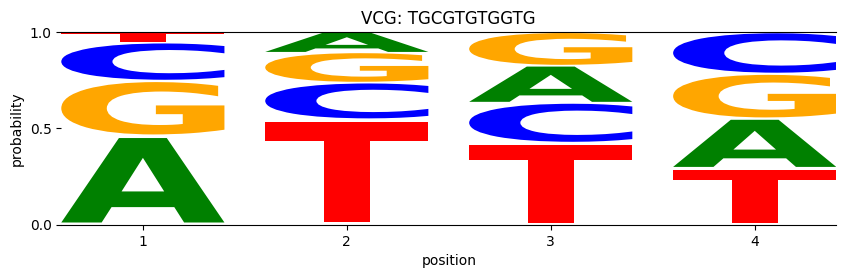

In [18]:
for VCG in VCG_DNA_list:
    base_probs  = base_probs_for_4N(VCG)

    if base_probs_are_abnormal(base_probs, max_prob_thresh=0.8, min_prob_thresh=0.06):
        print(base_probs)
        print(seq_logo_graph(base_probs, title=f"VCG: {VCG}"))

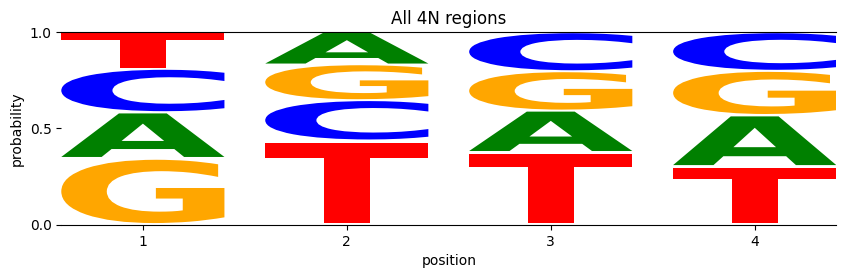

In [19]:
# Creating a Seq Logo using just the 4N column for all out data

vcg_4Ns = df_4N_VCG["4N"]

vcg_base_probs = {"A":[], "C":[], "T":[], "G":[]}

# There are 4 positions in our 4N sequence
for pos in range(4):

    # Counting how many times each base shows up in a specific position,
    # then dividing by the number of 4N replicas to give a probabilty.
    base_probs = vcg_4Ns.str[pos].value_counts() / len(vcg_4Ns)
    
    # Adding this probability to our dictionary
    for base in vcg_base_probs:
        vcg_base_probs[base].append(base_probs[base])

base_probs_df = pd.DataFrame(vcg_base_probs)

seq_logo_graph(base_probs_df, "All 4N regions")

In [20]:
base_probs_df

,A,C,T,G
0,0.238060,0.226441,0.189445,0.346054
1,0.166875,0.209808,0.437637,0.185680
2,0.215394,0.202639,0.377528,0.204439
3,0.266246,0.200195,0.303156,0.230403


In [21]:
for VCG in VCG_DNA_list:
    base_probs  = base_probs_for_4N(VCG)

    if base_probs_are_abnormal(base_probs, max_prob_thresh=0.8, min_prob_thresh=0.06):
        print(VCG)

GT
ATG
CAC
CGT
GCG
GGT
TGG
TGT
ACGC
GCGT
GTGT
TGCG
TGGT
ATGCG
CACGC
TGCGT
ACACGC
ATGCGT
GCGTGT
GTGGTG
TGTGGTG
ATGCGTGT
GTGTGGTG
TGCGTGTG
ATGCGTGTG
TGCGTGTGGTG


In [25]:
df_4N_VCG_group["Percent_Share"] = df_4N_VCG_group["Seq"].apply(lambda x: f"{round(x/198891, 3)}")
df_4N_VCG_group

,VCG_Len,VCG,Seq,Percent_Share
0,2,AC,1265,0.006
1,2,AT,760,0.004
2,2,CA,1081,0.005
3,2,CC,597,0.003
4,2,CG,1071,0.005
...,...,...,...,...
242,12,TCACCACACGCA,483,0.002
243,12,TGATGCGTGTGG,555,0.003
244,12,TGCGTGTGGTGA,553,0.003
245,12,TGGTGATGCGTG,582,0.003


### Analyzing any biases in the 5' 4N region. Since this region is not ligated using a mutated ligase, it makes sense that there are less biases here than in the 3' end.

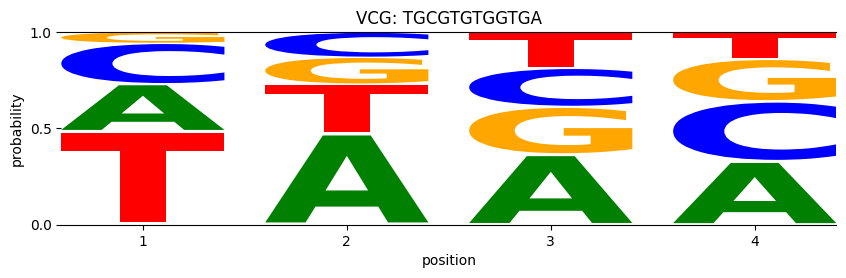

In [26]:
for VCG in VCG_DNA_list:
    base_probs = base_probs_for_5_adap_4N(VCG)

    max_prob = base_probs.to_numpy().max()
    min_prob = base_probs.to_numpy().min()

    if base_probs_are_abnormal(base_probs, max_prob_thresh=0.8, min_prob_thresh=0.06):
        print(seq_logo_graph(base_probs, title=f"VCG: {VCG}"))   

In [27]:
for VCG in VCG_DNA_list:
    base_probs = base_probs_for_4N(VCG)
    abnormal   = base_probs_are_abnormal(base_probs, max_prob_thresh=0.5, min_prob_thresh=0.1)

    max_prob = base_probs.to_numpy().max()
    min_prob = base_probs.to_numpy().min()

    # print(base_probs)
    if abnormal:
        print(VCG, max_prob, min_prob)
    # print(min_prob)
    # print(abnormal)

AC 0.3857707509881423 0.07351778656126483
AT 0.4631578947368421 0.08552631578947369
CC 0.4489112227805695 0.09882747068676717
GA 0.5749440715883669 0.0894854586129754
GT 0.8473895582329317 0.039491298527443104
TG 0.35124378109452736 0.09154228855721393
ACC 0.4665203073545554 0.06695938529088913
ACG 0.5328389830508474 0.08050847457627118
ATC 0.5698924731182796 0.0967741935483871
ATG 0.4354995150339476 0.05431619786614937
CAC 0.5437881873727087 0.05770536320434488
CAT 0.4965753424657534 0.08732876712328767
CGC 0.58399209486166 0.08201581027667984
CGT 0.9215155615696887 0.014884979702300407
GAT 0.5088633993743483 0.07507820646506778
GCA 0.46084828711256115 0.08401305057096248
GCG 0.5024330900243309 0.030413625304136254
GGT 0.7573839662447257 0.05485232067510549
GTG 0.4351520572450805 0.08273703041144902
TGA 0.49700598802395207 0.06387225548902195
TGC 0.46326836581709147 0.07646176911544228
TGG 0.41627906976744183 0.05930232558139535
TGT 0.8640522875816994 0.027450980392156862
ACAC 0.63038

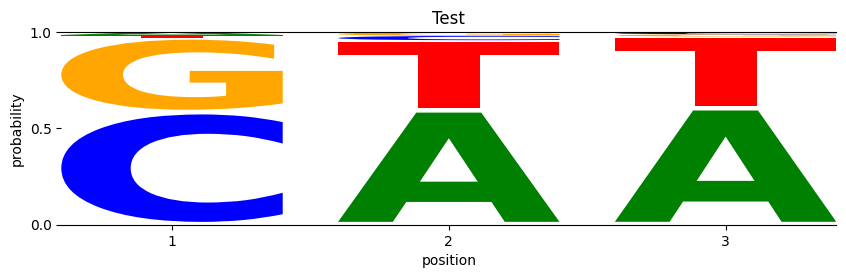

In [28]:
def df_2_seq_logo(df, column, title):
    '''
    Converts the column of a pandas DataFrame into a Seq Logo graph.
    All the entries in the column should be the same length, and should be
    sequence data (i.e. either A, C, T/U, or G).

    Args:
        df (pandas.DataFrame): DataFrame containing our column of sequence data
        column (str): Name of the column whose data we're converting into a graph
        title (str): Title at the top of the Seq Logo graph

    Returns:
        (logomaker.Logo): Sequence Logo graph showing the data from our desired column
    '''
    df_col   = df[column]
    num_seqs = len(df_col)
    seq_len  = len(df_col.iloc[0])

    # Creating dictionary of bases that we're going 
    # to populate later on.
    nucleotides = set(''.join(df_col)) # Unique nucleotides in our column
    nt_probs_dict = {nt:[] for nt in nucleotides}

    # Iterating through each position of the seqs. in our column
    for pos in range(seq_len):

        # Counting how many times each base shows up in a specific position,
        # then dividing by the number of 4N replicas to give a probabilty.
        pos_probs_df = df_col.str[pos].value_counts() / num_seqs
        
        # Adding the probability at this position to our dictionary
        for nt in nt_probs_dict:

            if nt in pos_probs_df:
                nt_probs_dict[nt].append(pos_probs_df[nt])
            else:
                # One of the nucleotides is missing at this position across our sequences
                nt_probs_dict[nt].append(0)
                
    
    # Create Logo object
    seq_logo = logomaker.Logo(pd.DataFrame(nt_probs_dict),
                            width=.8,
                            vpad=.05,
                            #  fade_probabilities=True,
                            stack_order='small_on_top',
                            color_scheme='classic')

    # Style using Logo methods
    seq_logo.style_spines(spines=['left', 'right'], visible=False)

    # Style using Axes methods
    seq_logo.ax.set_title(title)
    seq_logo.ax.set_xticks(range(seq_len))
    seq_logo.ax.set_xticklabels([str(i+1) for i in range(seq_len)])
    seq_logo.ax.set_xlabel('position')
    seq_logo.ax.set_yticks([0, .5, 1])
    # seq_logo.ax.axvline(2.5, color='k', linewidth=1, linestyle=':')
    seq_logo.ax.set_ylabel('probability')

    return seq_logo

df_2_seq_logo(df_4N_VCG, "MADAP_Code", title="Test")